In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import sys, os

from scipy.linalg import eigvalsh
from scipy.sparse import diags_array

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from notebook_functions import load_data

In [2]:
def tau_CFL_LF_all_coarse(matrix_path, data_str):
    indH, indE, mass_H, mass_E, inv_mass_H, inv_mass_E, curl_H, curl_E = load_data(matrix_path, data_str)
    cutoff_nonstiff = diags_array(np.concatenate((np.ones(indH[2]), np.zeros(indH[4] - indH[2])), axis=None), format='csr')
    curl_cutoff_curl = - curl_H @ inv_mass_H @ cutoff_nonstiff @ curl_E
    norm = np.max(eigvalsh(curl_cutoff_curl[:indH[3],:indH[3]].todense(), mass_E[:indH[3],:indH[3]].todense()))
    return np.sqrt(4.0 / norm)

## 1D

In [15]:
def plot_eta(path, data_str, etas, lfc_degrees, x_lim=None, y_lim=(1e-6, 100), leapfrog_on_coarse_cfl=None):
    count_etas = len(etas)
    fig, ax = plt.subplots(nrows=1, ncols=count_etas, sharey=True, figsize=(8, 8))
    if leapfrog_on_coarse_cfl:
        for i in range(count_etas):
            ax[i].vlines(leapfrog_on_coarse_cfl, *y_lim, linestyles='dashed', colors='k')

    for i in range(count_etas):
        for lfc_degree, color in zip(lfc_degrees, list(mcolors.TABLEAU_COLORS)):
            data = pd.read_table(path + 'errors_cavity_LTS_LFC_eta' + str(etas[i]).replace('.', ',') + data_str + '.txt', sep='|')
            data.drop(columns=data.columns[0], axis=1, inplace=True)
            data.columns = data.columns.str.strip()

            stepsizes = data['time step width'].unique()
            mask_large_vals = data['max l2 error'] >= 100
            data.loc[mask_large_vals, 'max l2 error'] = 1e20

            mask_lfc_degree = data['lfc degree'] == lfc_degree
            errors = data.loc[mask_lfc_degree, 'max l2 error']

            ax[i].loglog(stepsizes, errors, marker='.', linestyle='-',color=color, label=r"$p$ = " + str(lfc_degree))

        # order line
        ord_2_line = 0.5 * errors.values[-1] / stepsizes[-1]**2
        ax[i].loglog(stepsizes, ord_2_line*stepsizes**2, linestyle='--', color='gray', label=r"$\mathcal{O}(\tau^2)$")
    
        ax[i].legend(loc='upper left')
        ax[i].set_xlabel("time stepsize")
        ax[i].set_title(f"eta = {etas[i]}")
        ax[i].set_box_aspect(1)
        if x_lim: ax[i].set_xlim(x_lim)

    ax[0].set_ylim(y_lim)
    ax[0].set_ylabel(r"max $L^2$ error")
    plt.tight_layout()
    plt.show()

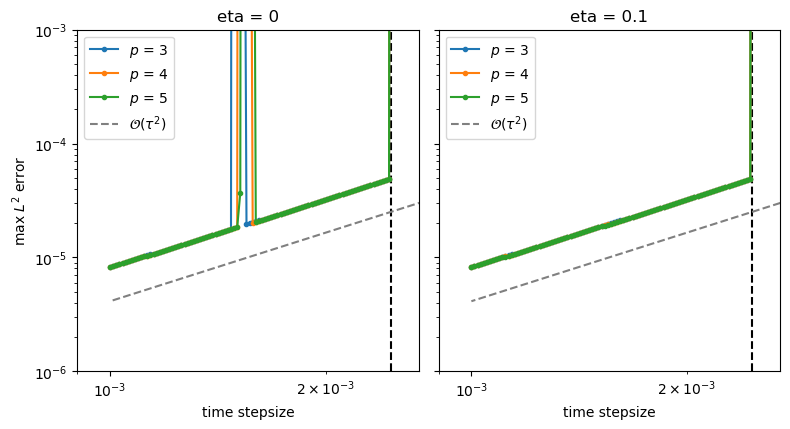

In [16]:
lfc_degrees = [3, 4, 5]
etas = [0, 0.1]

ratio = 4
dg = 2

matrix_path = "../../build/1D-example/convergence/matrices/"
data_path = "../../build/1D-example/convergence/"
data_str = '_dg' + str(dg) + '_coarse-fine-ratio' + str(ratio)

CFL_LF_coarse = tau_CFL_LF_all_coarse(matrix_path, data_str)

plot_eta(data_path, data_str, etas, lfc_degrees, x_lim=(9e-4, 2.7e-3), y_lim=(1e-6, 1e-3), leapfrog_on_coarse_cfl=CFL_LF_coarse)